# Getting started with the Millennium Development Goals challenge

-----------

### This notebook is available for [viewing](http://nbviewer.ipython.org/gist/pjbull/c3b7a16fe5a690813c09) and [download](https://gist.githubusercontent.com/pjbull/c3b7a16fe5a690813c09/raw/5a92f81bb230742e9bca853222e2653ff641a5a2/World%20Bank%20-%20Getting%20Started.ipynb) NBViewer and as a Github gist.

----------

People have been a little reticent to start digging in to the [Millenium Development Goals](http://www.drivendata.org/competitions/1/) challenge. We thought a little sample code might help get things started.

The UN measures progress towards Millennium Development Goals using macroeconomic indicators such as percent of the population making over one dollar per day. Each goal has one or more targets, and each target has one or more indicators. Of the 60 indicators in all, we've chosen a subset to focus on for this challenge. Your task is to predict the change in these indicators one year and five years into the "future" from the year 2007.

Predicting future progress will help us to understand how we achieve these goals by uncovering complex relations between these goals and other economic indicators. The UN set 2015 as the target for measurable progress. Given the data from 1972 - 2007, you need to predict a specific indicator for each of these goals in 2008 and 2012.

This notebook contains three sections

 - [Digging into the Data](#digging)
 - [Making a simple model](#model)
 - [Starting to think about correlations](#correlations)
 
We'll get started by loading the python modules in our analysis toolkit.

In [6]:
%matplotlib inline

# data manipulation and modeling
import numpy as np
import pandas as pd
import statsmodels.api as sm

# graphix
import matplotlib.pyplot as plt
import prettyplotlib as pplt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsaplots

# utility
import os

# notebook parameters
pd.set_option('display.max_columns', 40) # number of columns in training set
plt.rcParams['figure.figsize'] = (14.0, 8.0)

<a id="digging"></a>

# Digging into the data

---------------


Time to go get that data. We've downloaded the data from [the competition data download page](http://www.drivendata.org/competitions/1/data/). We've put it in a folder called `data` in the same directory as this notebook. Now we can load in the data into the IPython notebook.  There are two files here:

 - **Training Set** - This contains all of the timeseries values for 241 countries, for 1337 indicators from 1970 - 2007. We've downloaded and unzipped the archive in our `data` folder, so we are working with the CSV file.
 
 - **Submission Rows** - This contains the rows and format for our submission. We need to predict the values in 2008 and 2012 for the time series with IDs in this file.

In [8]:
training_data = pd.read_csv("TrainingSet.csv", index_col=0)
submission_labels = pd.read_csv("SubmissionRows.csv", index_col=0)

In [2]:
training_data.head()

NameError: name 'training_data' is not defined

Poking around, we can see that there are entries for 1972 - 2007 for many different countries for many different macroeconomic indicators. Also, **it's important to note**, there are lots of `NaN`'s. The best solutions will have good ways to handle missing values. For now, we'll ignore them.

In [4]:
submission_labels.head()

,2008 [YR2008],2012 [YR2012]
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN


Submission labels are simpler. First observation is we want to predict 2008 and 2012 (and not the years in between). Second observation is that the index values indentify specific rows in the training set. E.g., we want to predict the row in the training set that has the ID 559. Just to look that up:

In [5]:
training_data.loc[559]

1972 [YR1972]                                    NaN
1973 [YR1973]                                    NaN
1974 [YR1974]                                    NaN
1975 [YR1975]                                    NaN
1976 [YR1976]                                    NaN
1977 [YR1977]                                    NaN
1978 [YR1978]                                    NaN
1979 [YR1979]                                    NaN
1980 [YR1980]                                    NaN
1981 [YR1981]                                    NaN
1982 [YR1982]                                    NaN
1983 [YR1983]                                    NaN
1984 [YR1984]                                    NaN
1985 [YR1985]                                    NaN
1986 [YR1986]                                    NaN
1987 [YR1987]                                    NaN
1988 [YR1988]                                    NaN
1989 [YR1989]                                    NaN
1990 [YR1990]                                 

And now we can see that we want to predict the time series for the [Millennium Development Goal 7.8](http://unstats.un.org/unsd/mdg/Host.aspx?Content=Indicators/OfficialList.htm), which is about ensuring environmental sustainability.

We're almost to the fun part. But first let's just write a little utility function to keep us sane. We noticed that the year columns have annoying titles (sorry!). We'll write a little function that will make it easier to grab any column that we want.

In [6]:
def generate_year_list(start, stop=None):
    """ 
    make a list of column names for specific years
    in the format they appear in the data frame start/stop inclusive
    """
    
    if isinstance(start, list):
        data_range = start
    elif stop:
        data_range = range(start, stop+1)
    else:
        data_range = [start]
    
    yrs = []
    
    for yr in data_range:
        yrs.append("{0} [YR{0}]".format(yr))
        
    return yrs

# ========== TEST CASES =======
# one year
print generate_year_list(2008)

# start and stop (inclusive)
print generate_year_list(1985, 1990)

# custom year list
print generate_year_list([1985, 1990])

['2008 [YR2008]']
['1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]']
['1985 [YR1985]', '1990 [YR1990]']


Alright, let's start by looking at the time series that we want to predict. In `pandas` it's pretty easy to grab just those rows from the training set since we have the IDs in `submission_labels`. Also, to make our lives easier, we'll drop the info about what these rows are. We can always grab that again from the training data when we want. This way we're just looking at the numeric matrix. 

In [7]:
prediction_rows = training_data.loc[submission_labels.index]
prediction_rows = prediction_rows[generate_year_list(1972, 2007)]
prediction_rows.head()

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007]
559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0480,0.0490,0.0490,0.0490,0.0490,0.0840,0.1180,0.1520,0.1870,0.2210,0.256000,0.291000,0.325000,0.360000,0.395000,0.430000,0.4650
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000047,0.000046,0.000879,0.001058,0.012241,0.021071,0.0190
753,0.296,0.2909,0.2852,0.2798,0.2742,0.2683,0.2624,0.2565,0.2503,0.2439,0.2374,0.2304,0.2229,0.2151,0.2071,0.1993,0.1914,0.1836,0.1762,0.1693,0.1627,0.1571,0.1521,0.1479,0.1446,0.1417,0.1391,0.1366,0.1339,0.131000,0.127700,0.124400,0.121000,0.117700,0.114500,0.1115
1030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.0010
1896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9640,0.9640,0.9650,0.9650,0.9650,0.9650,0.9650,0.964000,0.964000,0.963000,0.963000,0.962000,0.962000,0.9610


Now let's just get a visual sense of what some of these look like. We'll grab 10 of the series at random and plot them below.

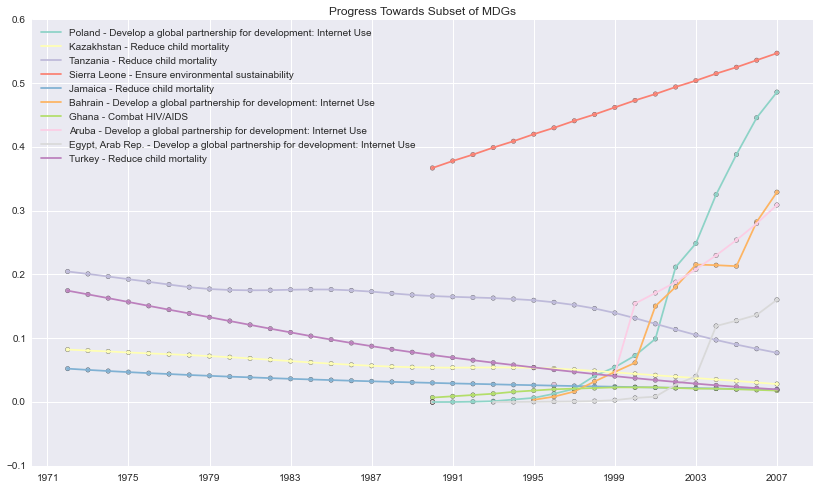

In [8]:
# grab a random sample of 10 of the timeseries
np.random.seed(896)
rand_rows = np.random.choice(prediction_rows.index.values, size=10)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10)
    colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, c=colors[i],
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8, c=colors[i])

    if legend:
        plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(prediction_rows, ids=rand_rows)
plt.show()

<a id="model"></a>

# Making a simple model

<hr>

We'll start with a super simple model. If we only have data for 2007 and not before, we'll predict that value for 2008 and 2012. If we have more data, we'll do a simple linear regression using just the data points for 2006 and 2007. Our prediction will be that the line which passes through 2006 and 2007 also passes through 2008 and 2012. Hey, maybe you can think of something even more clever to **[move you up the leaderboard](http://www.drivendata.org/competitions/1/leaderboard/)**!

In [9]:
def simple_model(series):
    point_2007 = series.iloc[-1]
    point_2006 = series.iloc[-2]
    
    # if just one point, status quo
    if np.isnan(point_2006):
        predictions = np.array([point_2007, point_2007])
    else:
        slope = point_2007 - point_2006
        
        # one year
        pred_2008 = point_2007 + slope
        
        # five years
        pred_2012 = point_2007 + 5*slope
        
        predictions = np.array([pred_2008, pred_2012])

    ix = pd.Index(generate_year_list([2008, 2012]))
    return pd.Series(data=predictions, index=ix)
        
# let's try just these predictions on the first five rows
test_data = prediction_rows.head()
test_predictions = test_data.apply(simple_model, axis=1)

# combine the data and the predictions
test_predictions = test_data.join(test_predictions)

# let's take a look at 2006, 2007, and our predictions
test_predictions[generate_year_list([2006, 2007, 2008, 2012])]

,2006 [YR2006],2007 [YR2007],2008 [YR2008],2012 [YR2012]
559,0.430000,0.4650,0.500000,0.640000
618,0.021071,0.0190,0.016929,0.008644
753,0.114500,0.1115,0.108500,0.096500
1030,0.001000,0.0010,0.001000,0.001000
1896,0.962000,0.9610,0.960000,0.956000


OK, so our dead-simple regression is working. Let's see how it looks when we combine it with the data that we graphed earlier. 

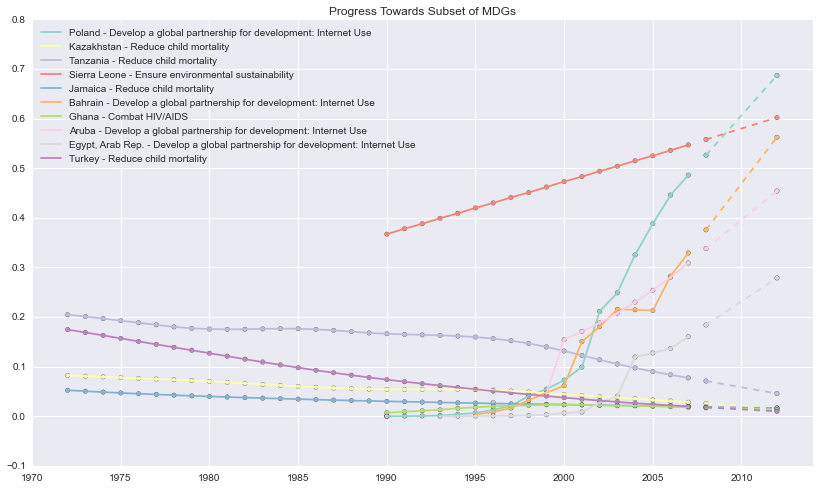

In [10]:
# make the predictions
predictions = prediction_rows.loc[rand_rows].apply(simple_model, axis=1)

# plot the data
plot_rows(prediction_rows, ids=rand_rows)

# plot the predictions
plot_rows(predictions, linestyle="--", legend=False)

plt.show()

We've made some predictions!  These don't look too crazy, so let's write out a submission file that we can upload on on the [competition submissions page](http://www.drivendata.org/competitions/1/submissions/). We've put together a little utility function that will write out the submissions in the right format. It will accept the following data structures:

 - `pandas.DataFrame` - with index and columns that are already specified properly (as in this notebook)
 - `numpy.array` - with 2 columns (just the predictions) or 3 columns (id, 2008, 2012)
 - `list` - must be a list with two lists as its elements; the first, 2008, the second, 2012
 - `dict` - must have two keys that match the prediction indices ('2008 [YR2008]', '2012 [YR2012]') with values that are a list of predictions

In [11]:
def write_submission_file(preds, filename):
    # load the submission labels
    file_format = pd.read_csv(os.path.join("data", "SubmissionRows.csv"), index_col=0)
    expected_row_count = file_format.shape[0]

    if isinstance(preds, pd.DataFrame):
        # check indices
        assert(preds.index == file_format.index).all(), \
            "DataFrame: Prediction indices must match submission format."
        
        # check columns
        assert (preds.columns == file_format.columns).all(), \
            "DataFrame: Column names must match submission format."
        
        final_predictions = preds
        
    elif isinstance(preds, np.ndarray):
        rows, cols = preds.shape
        
        if cols == 3:
            assert (preds[:,0] == file_format.index.values).all(), \
                "Numpy Array: First column must be indices."
            
            # now we know the indices are cool, ditch them
            preds = preds[:,1:]
        
        assert rows == expected_row_count, \
            "Numpy Array: The predictions must have the right number of rows."
        
        # put the predictions into the dataframe
        final_predictions = file_format.copy()
        final_predictions[generate_year_list([2008, 2012])] = preds
            
    elif isinstance(preds, list):
        assert len(preds) == 2, \
            "list: Predictions must be a list containing two lists"
        assert len(preds[0]) == expected_row_count, \
            "list: There must be the right number of predictions in the first list."
        assert len(preds[1]) == expected_row_count, \
            "list: There must be the right number of predictions in the second list."
    
        # write the predictions
        final_predictions = file_format.copy()
        final_predictions[generate_year_list(2008)] = np.array(preds[0], dtype=np.float64).reshape(-1, 1)
        final_predictions[generate_year_list(2012)] = np.array(preds[1], dtype=np.float64).reshape(-1, 1)
        
    elif isinstance(preds, dict):
        assert preds.keys() == generate_year_list([2008, 2012]), \
            "dict: keys must be properly formatted"
        assert len(preds[generate_year_list(2008)[0]]) == expected_row_count, \
            "dict: length of value for 2008 must match the number of predictions"
        assert len(preds[generate_year_list(2012)[0]]) == expected_row_count, \
            "dict: length of value for 2012 must match the number of predictions"
        
        # create dataframe from dictionary
        final_predictions = pd.DataFrame(preds, index=file_format.index)

    final_predictions.to_csv(filename)
    
simple_predictions = prediction_rows.apply(simple_model, axis=1)
write_submission_file(simple_predictions, "Getting Started Benchmark.csv")

<a id="correlations"></a>

# Starting to think about correlations

<hr>

We won't make any prediction based on this section of the notebook (that's up to you!), but one hypothesis you might have is that certain other timeseries are correlated with the ones we want to predict.

As an example, say we are looking at GDP and percent of population that makes under a dollar a day (PLDD). You may think that an increase in GDP during 2006-2007 would entail a decrease PLDD during 2007-2008. Similarly a decrease during 2006-2007 in GDP would result in an increase in PLDD. 

We might call this a lagged correlation. As an experiment, we'll pick one country, Kenya, and make a correlation matrix between all of the indicators.

In [12]:
kenya_data = training_data[training_data["Country Name"] == 'Kenya']
kenya_values = kenya_data[generate_year_list(1972, 2007)].values

# get the total number of time series we have for Kenya
nseries = kenya_values.shape[0]

# -1 as default
lag_corr_mat = np.ones([nseries, nseries], dtype=np.float64)*-1

# create a matrix to hold our lagged correlations
for i in range(nseries):
    for j in range(nseries):
        # skip comparing a series with itself
        if i!=j:
            # get original (1972-2006) and shifted (1973-2007)
            original = kenya_values[i,1:]
            shifted = kenya_values[j,:-1]

            # for just the indices where neither is nan
            non_nan_mask = (~np.isnan(original) & ~np.isnan(shifted))

            # if we have at least 2 data points
            if non_nan_mask.sum() >= 2:
                lag_corr_mat[i,j] = np.correlate(original[non_nan_mask], shifted[non_nan_mask])

Finally, let's see what the most correlated lagged time series is for one of the rows we have to predict. I happen to know that the row with the index 131042 is one we need to predict.

In [13]:
# let's look at one of the indicators we are suppoed to predict
to_predict_ix = 131042 

# first, we get the index of that row in the correlation matrix
i = np.where(kenya_data.index.values == to_predict_ix)[0][0]

# then, we see which value in the matrix is the largest for that row
j_max = np.argmax(lag_corr_mat[i,:])

# finally, let's see what these correspond to
max_corr_ix = kenya_data.index.values[j_max]

# now write out what we've found
fmt_string = "In Kenya, the progress of '{}' is "\
    "most correlated with a change in '{}' during the year before."
    
print fmt_string.format(kenya_data["Series Name"][to_predict_ix], kenya_data["Series Name"][max_corr_ix])

In Kenya, the progress of 'Achieve universal primary education' is most correlated with a change in 'Gross national expenditure (current LCU)' during the year before.


Hey, that's actually plausible! Awesome!

That's all for now. It's your turn to uncover some of these interesting structures yourself and [gain some notoreity](http://www.drivendata.org/competitions/1/) along the way.

If you're looking for a place to start, Hyndman's open textbook ["Forecasting: principles and practice"](https://www.otexts.org/fpp/) will definitely give you some ideas. Code snippets are in R, but translatable to Python.

# Use this notebook as a jumping off point and [make some submissions](http://www.drivendata.org/competitions/1/). Good luck!